In [87]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [88]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [153]:
cutoff_date = '2022-12-31' ## len = 65
test_period = 12 ## 예측 기간 (월)
corr_rate = 0.7 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 5
hist_variable_limit = 10

## <원 data set>

In [154]:
df = pd.read_csv('./data/metal_pst_2.csv')

df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
# df.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
# df.rename(columns={'li2co3_995_am_kg':'y3'},inplace=True)
# df.rename(columns={'li2co3_exw_fast_kg':'y4'},inplace=True)
# df.rename(columns={'lioh_exw_fast_kg':'y5'},inplace=True)
# df.rename(columns={'ni_lme_kg':'y6'},inplace=True)
# df.rename(columns={'co_mb_kg':'y7'},inplace=True)
# df.rename(columns={'mn_mb_kg':'y8'},inplace=True)
# df.rename(columns={'cu_lme_kg':'y9'},inplace=True)
# df.rename(columns={'al_lme_kg':'y10'},inplace=True)
# df.rename(columns={'w_mb_mtu':'y11'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')


df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)

del raw_y_set_resampled['unique_id']

## Feature shift

In [155]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 13.2 s
Wall time: 28.8 s


#### 해당 기간에서의 lag corr best

In [156]:
raw_y_set_shifted_merged

,date,y,y_12_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_12_,Howe Robinson Container Index,Howe Robinson Container Index_12_,Shanghai Containerized Freight Index (SCFI),Shanghai Containerized Freight Index (SCFI)_12_,lioh_mag_am_kg,...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_12_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_12_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_12_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_12_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_12_
0,2016-01-31,20.177268,NaN,-1.302468,NaN,-0.644064,NaN,-0.195705,NaN,-0.234687,...,-0.915916,NaN,-0.911882,NaN,-0.921663,NaN,-0.909069,NaN,-0.909069,NaN
1,2016-02-29,23.306868,NaN,-1.396112,NaN,-0.645288,NaN,-0.182527,NaN,-0.044482,...,-0.910118,NaN,-0.915569,NaN,-0.908508,NaN,-0.916207,NaN,-0.916207,NaN
2,2016-03-31,25.223010,NaN,-1.305967,NaN,-0.644523,NaN,-0.362815,NaN,0.151733,...,-0.833402,NaN,-0.834459,NaN,-0.834589,NaN,-0.834453,NaN,-0.834453,NaN
3,2016-04-30,25.308243,NaN,-1.041598,NaN,-0.648195,NaN,-0.472294,NaN,0.192821,...,-0.691659,NaN,-0.695181,NaN,-0.693237,NaN,-0.700107,NaN,-0.700107,NaN
4,2016-05-31,24.875099,NaN,-1.026945,NaN,-0.645747,NaN,-0.487834,NaN,0.123852,...,-0.497700,NaN,-0.494779,NaN,-0.496022,NaN,-0.493870,NaN,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2022-08-31,73.000000,14.590909,-0.092744,2.629514,2.119559,1.687843,2.773368,-0.078270,2.326969,...,2.144853,1.083831,2.155770,1.090253,2.181382,1.075285,2.184215,1.087407,2.184215,1.087407
80,2022-09-30,74.047619,19.083333,-0.004062,3.299182,1.188816,1.991462,3.024986,0.100634,2.277420,...,2.828439,1.124191,2.823884,1.123562,2.834908,1.129411,2.836251,1.129772,2.836251,1.129772
81,2022-10-31,77.673913,22.750000,0.381286,3.926870,0.204375,1.998856,3.036207,0.187008,2.483672,...,2.765597,1.020054,2.782167,1.006143,2.764528,1.008416,2.761120,1.008169,2.761120,1.008169
82,2022-11-30,80.818182,28.170455,-0.226024,1.521353,-0.008117,1.794166,3.004479,0.556798,2.751976,...,2.830058,1.240984,2.817705,1.248657,2.816214,1.253894,2.795982,1.257281,2.795982,1.257281


In [157]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]

# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [158]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y
HOUSECOST_FIN_12_,0.947197
1772.HK(Ganfeng Lithium)_Price_Low_12_,0.936926
1772.HK(Ganfeng Lithium)_Price_Open_12_,0.936095
1772.HK(Ganfeng Lithium)_Price_Close_12_,0.935680
1772.HK(Ganfeng Lithium)_Price_Adj Close_12_,0.935270


In [159]:
futr_list

['HOUSECOST_FIN',
 '1772.HK(Ganfeng Lithium)_Price_Low',
 '1772.HK(Ganfeng Lithium)_Price_Open',
 '1772.HK(Ganfeng Lithium)_Price_Close',
 '1772.HK(Ganfeng Lithium)_Price_Adj Close']

#### 해당 기간에서의 corr best

In [160]:
hist_variable_limit

10

In [161]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

['CPI_BEL_TOT_AGRWTH',
 'CPI_PRT_TOT_FOODENRG_AGRWTH',
 'CPI_PRT_TOT_AGRWTH',
 'CPI_LTU_TOT_AGRWTH',
 'CPI_GBR_TOT_FOODENRG_AGRWTH',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 'CPI_OECD_TOT_FOODENRG_AGRWTH',
 'CPI_TUR_ENRG_AGRWTH',
 'CPI_EST_TOT_FOODENRG_AGRWTH',
 'CPI_DNK_ENRG_IDX2015']

In [162]:
hist_var_corr_filtered_y_only

,y
CPI_BEL_TOT_AGRWTH,0.967959
CPI_PRT_TOT_FOODENRG_AGRWTH,0.967403
CPI_PRT_TOT_AGRWTH,0.963821
CPI_LTU_TOT_AGRWTH,0.952014
CPI_GBR_TOT_FOODENRG_AGRWTH,0.950771
...,...
CPI_BEL_ENRG_IDX2015,0.903224
CPI_LTU_ENRG_AGRWTH,0.902471
CPI_POL_ENRG_IDX2015,0.902469
CPI_FRA_TOT_AGRWTH,0.901984


#### static DF

In [163]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [164]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [165]:
# len(df.loc[df.ds<'2021-06-30'])

In [166]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [167]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [168]:
futr_list

['HOUSECOST_FIN',
 '1772.HK(Ganfeng Lithium)_Price_Low',
 '1772.HK(Ganfeng Lithium)_Price_Open',
 '1772.HK(Ganfeng Lithium)_Price_Close',
 '1772.HK(Ganfeng Lithium)_Price_Adj Close']

In [169]:
# futr_list = [
#              'Baltic Dry Index (BDI)',
#              'Howe Robinson Container Index',
#              # 'Shanghai Containerized Freight Index (SCFI)',
#              # 'lioh_mag_am_kg',
#              # 'LGES 리튬소요량_수산화리튬(kg)',
#              # '옥수수 For Grain [미국(생산자 가격)] 현물',
#              # '대두 [미국(생산자 가격)] 현물',
#              # '대두박 [파라나구아(FOB)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              # 'LGES 리튬소요량_탄산리튬(kg)',
#              # 'Pilbara Mineral Limited price Open',
#              # 'li2co3_cif_fast_kg_spot_exchng'
#              # '미국 비농업부분고용',
#             ]

In [170]:
Y_test_df_list = list(Y_test_df)
Y_test_df_list = [x for x in Y_test_df_list if x not in futr_list]
Y_test_df_list[3:3] = futr_list
Y_test_df = Y_test_df[Y_test_df_list]

Y_train_df_list = list(Y_train_df)
Y_train_df_list = [x for x in Y_train_df if x not in futr_list]
Y_train_df_list[3:3] = futr_list
Y_train_df = Y_train_df[Y_train_df_list]

In [171]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close
0,2023-01-31,A,0.744984,1.586656,1.591698,1.585566,1.583227
1,2023-02-28,A,0.744984,1.728255,1.749242,1.743348,1.740182
2,2023-03-31,A,0.744984,1.407937,1.389449,1.384712,1.383427
3,2023-04-30,A,0.716308,1.141380,1.132464,1.134450,1.134478
4,2023-05-31,A,0.716308,1.063306,1.087993,1.077455,1.077782
5,2023-06-30,A,0.716308,1.394566,1.423868,1.430067,1.439884
6,2023-07-31,A,3.046615,1.369106,1.377769,1.352985,1.371378
7,2023-08-31,A,3.046615,1.179453,1.206883,1.188562,1.206447
8,2023-09-30,A,3.046615,0.917671,0.933301,0.907518,0.924534
9,2023-10-31,A,3.167846,0.639685,0.654932,0.640460,0.656652


#### No 변수

In [172]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [173]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [174]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [175]:
Y_train_df

,ds,unique_id,y,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close,Baltic Dry Index (BDI),Howe Robinson Container Index,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2016-01-31,A,20.177268,-0.697250,-0.711620,-0.708309,-0.710711,-0.712605,-1.302468,-0.644064,...,-0.831670,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069
1,2016-02-29,A,23.306868,-0.697250,-0.711620,-0.708309,-0.710711,-0.712605,-1.396112,-0.645288,...,-0.748690,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207
2,2016-03-31,A,25.223010,-0.697250,-0.711620,-0.708309,-0.710711,-0.712605,-1.305967,-0.644523,...,-0.731866,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453
3,2016-04-30,A,25.308243,-0.671888,-0.711620,-0.708309,-0.710711,-0.712605,-1.041598,-0.648195,...,-0.520540,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107
4,2016-05-31,A,24.875099,-0.671888,-0.711620,-0.708309,-0.710711,-0.712605,-1.026945,-0.645747,...,-0.375846,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2022-08-31,A,73.000000,3.046615,1.206883,1.179453,1.188562,1.206447,-0.092744,2.119559,...,2.219001,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215
80,2022-09-30,A,74.047619,3.046615,0.933301,0.917671,0.907518,0.924534,-0.004062,1.188816,...,2.107414,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251
81,2022-10-31,A,77.673913,3.167846,0.654932,0.639685,0.640460,0.656652,0.381286,0.204375,...,2.352264,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120
82,2022-11-30,A,80.818182,3.167846,0.938983,0.920304,0.936081,0.953186,-0.226024,-0.008117,...,2.433279,2.443712,2.455263,2.452607,2.303940,2.830058,2.817705,2.816214,2.795982,2.795982


In [176]:
futr_list

['HOUSECOST_FIN',
 '1772.HK(Ganfeng Lithium)_Price_Low',
 '1772.HK(Ganfeng Lithium)_Price_Open',
 '1772.HK(Ganfeng Lithium)_Price_Close',
 '1772.HK(Ganfeng Lithium)_Price_Adj Close']

In [ ]:
if len(Y_test_df) > 0:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_list

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=horizon, input_size=5 * horizon,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,
          #       # hist_exog_list = hist_list,
          #       # futr_exog_list = None,  
          #       futr_exog_list = flexible,
          #       learning_rate=1e-4,
          #       mlp_units = [[512, 512], [512, 512], [512, 512]],
          #       batch_size=128,
          #       random_seed=42,
          #       n_blocks=[1, 1, 1],
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #       max_steps=30
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_list,
                # futr_exog_list = flexible,
                futr_exog_list = None,
                # futr_exog_list = futr_list,
                # n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'robust',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=200
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='standard',
          #        learning_rate=1e-4,
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=flexible,
          #        hist_exog_list=None,
          #        stat_exog_list=None,
          #        max_steps=200
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     hidden_size=128,
          #     # n_head=4, 
          #     attn_dropout=0.2,
          #     # hist_exog_list=hist_list,
          #     dropout=0.6,
          #     learning_rate=1e-4,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     # enable_progress_bar=True,
          #     max_steps=200
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=df)
# Y_hat_df = nforecast.predict(futr_df=futr_df)
Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

In [192]:
futr_df

,ds,unique_id,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close,y,Baltic Dry Index (BDI),Howe Robinson Container Index,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2023-01-31,A,0.744984,1.586656,1.591698,1.585566,1.583227,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2023-02-28,A,0.744984,1.728255,1.749242,1.743348,1.740182,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2023-03-31,A,0.744984,1.407937,1.389449,1.384712,1.383427,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2023-04-30,A,0.716308,1.141380,1.132464,1.134450,1.134478,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2023-05-31,A,0.716308,1.063306,1.087993,1.077455,1.077782,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,2023-06-30,A,0.716308,1.394566,1.423868,1.430067,1.439884,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,2023-07-31,A,3.046615,1.369106,1.377769,1.352985,1.371378,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,2023-08-31,A,3.046615,1.179453,1.206883,1.188562,1.206447,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,2023-09-30,A,3.046615,0.917671,0.933301,0.907518,0.924534,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,2023-10-31,A,3.167846,0.639685,0.654932,0.640460,0.656652,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [193]:
Y_test_df

,ds,unique_id,y,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close,Baltic Dry Index (BDI),Howe Robinson Container Index,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close


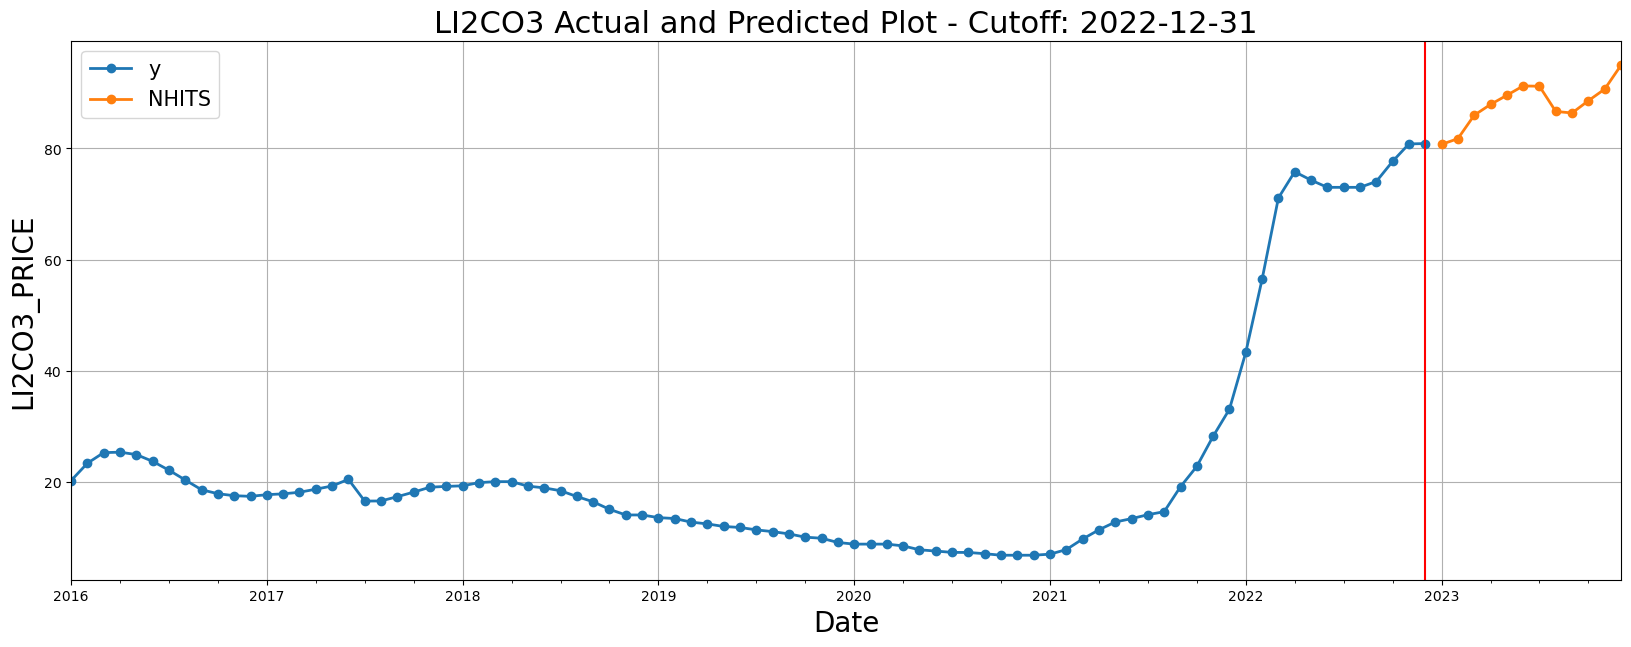

In [194]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

if len(Y_test_df) > 0:
    Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
else:
    plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [195]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [196]:
Y_hat_df

,unique_id,ds,NHITS
0,A,2023-01-31,80.737465
1,A,2023-02-28,81.761589
2,A,2023-03-31,85.977509
3,A,2023-04-30,87.925400
4,A,2023-05-31,89.572899
5,A,2023-06-30,91.259216
6,A,2023-07-31,91.209007
7,A,2023-08-31,86.667641
8,A,2023-09-30,86.388794
9,A,2023-10-31,88.599274


In [190]:
futr_df

,ds,unique_id,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close,y,Baltic Dry Index (BDI),Howe Robinson Container Index,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2023-01-31,A,0.744984,1.586656,1.591698,1.585566,1.583227,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2023-02-28,A,0.744984,1.728255,1.749242,1.743348,1.740182,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2023-03-31,A,0.744984,1.407937,1.389449,1.384712,1.383427,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2023-04-30,A,0.716308,1.141380,1.132464,1.134450,1.134478,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2023-05-31,A,0.716308,1.063306,1.087993,1.077455,1.077782,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,2023-06-30,A,0.716308,1.394566,1.423868,1.430067,1.439884,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,2023-07-31,A,3.046615,1.369106,1.377769,1.352985,1.371378,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,2023-08-31,A,3.046615,1.179453,1.206883,1.188562,1.206447,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,2023-09-30,A,3.046615,0.917671,0.933301,0.907518,0.924534,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,2023-10-31,A,3.167846,0.639685,0.654932,0.640460,0.656652,None,None,None,...,None,None,None,None,None,None,None,None,None,None
